In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [4]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [5]:
df['day_direction'].value_counts(normalize = True)

1    0.54024
0    0.45976
Name: day_direction, dtype: float64

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df.columns

Index(['low', 'open', 'volume', 'high', 'close', 'adjustedclose', 'rsi',
       'BBB_5_2.0', 'BBP_5_2.0', 'ema7', 'day_direction',
       'golden_crossover_short', 'death_crossover_short',
       'golden_crossover_long', 'death_crossover_long', 'RSI_overbought_cross',
       'RSI_oversold_cross', 'RSI_overbought', 'RSI_oversold', 'momentum',
       'psr', 'ir', 'ffer', 'sp500_return', 'sp500_BBB_5_2.0',
       'sp500_BBP_5_2.0'],
      dtype='object')

In [8]:
df = df[['low', 'open', 'volume', 'high', 'close', 'adjustedclose', 'rsi',
       'BBB_5_2.0', 'BBP_5_2.0', 'ema7', 'day_direction',
       'golden_crossover_short', 'death_crossover_short',
       'golden_crossover_long', 'death_crossover_long', 'RSI_overbought_cross',
       'RSI_oversold_cross', 'RSI_overbought', 'RSI_oversold', 'momentum']]

In [9]:
X = df.shift(1).dropna()
y = df['adjustedclose'].iloc[1:]

In [10]:
train_num = round(len(X)*.8)
test_num = round(len(X)*.2)
print(train_num, test_num)

1798 450


In [11]:
X_train = X.iloc[:train_num]
X_test = X.iloc[-test_num:]
y_train = y.iloc[:train_num]
y_test = y.iloc[-test_num:]

In [12]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)

In [13]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [14]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [15]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9984579283224139
Train RMSE : 23.344423601788982
Mean Train Cross-Validation Score: 0.3120134390286805


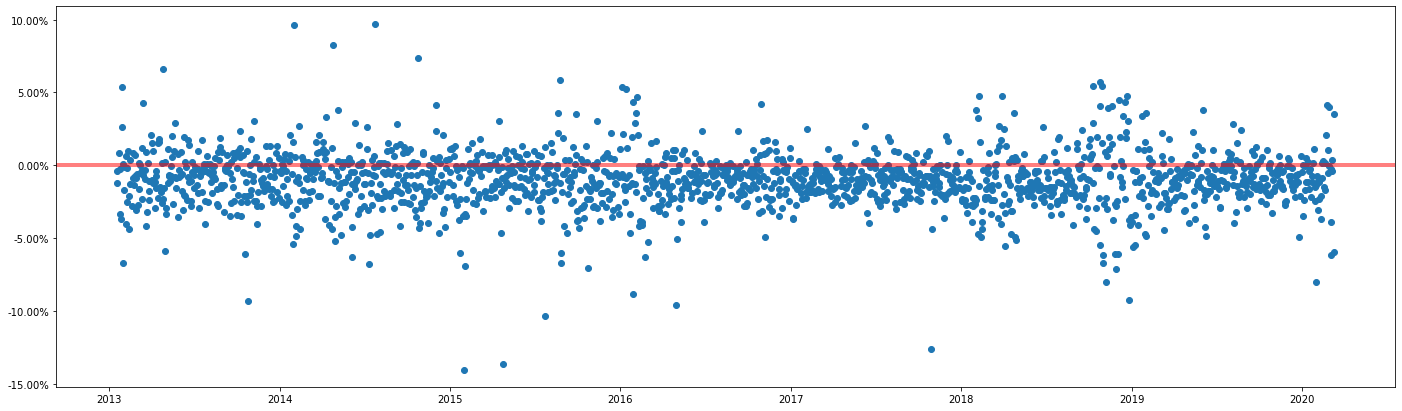

In [16]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [17]:
test_score = svr.score(X_test_scaled, y_test)
y_hat_test = svr.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(f'Test Score : {test_score}')
print(f'Test RMSE : {test_rmse}')

Test Score : 0.9724877582241126
Test RMSE : 69.3390878617976


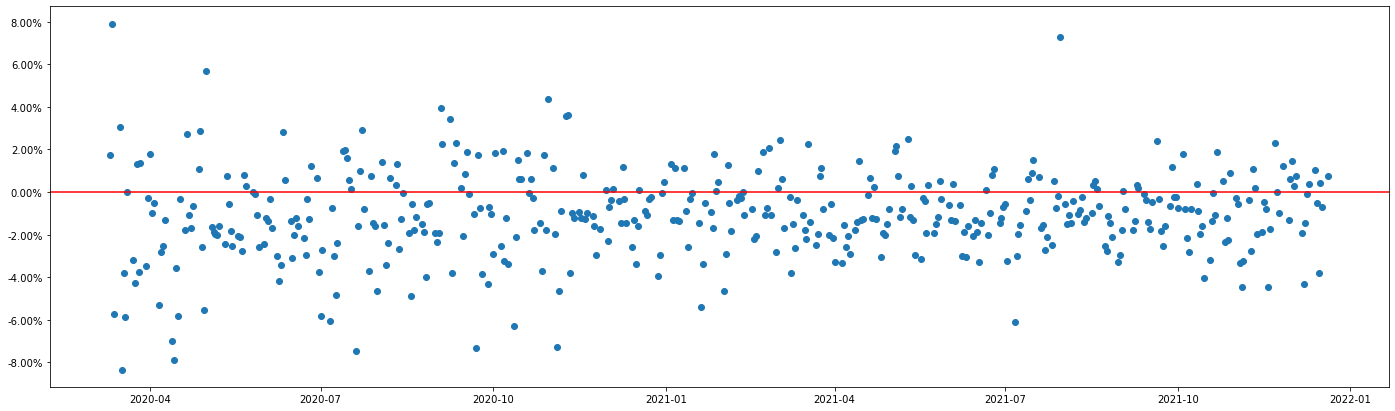

In [18]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

In [19]:
preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
preds_train.dropna(inplace = True)

In [20]:
preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
preds_train['correct'].value_counts(normalize = True)

0    0.531146
1    0.468854
Name: correct, dtype: float64

In [21]:
preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
preds_test.dropna(inplace = True)

In [22]:
preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
preds_test['correct'].value_counts(normalize = True)

0    0.542222
1    0.457778
Name: correct, dtype: float64

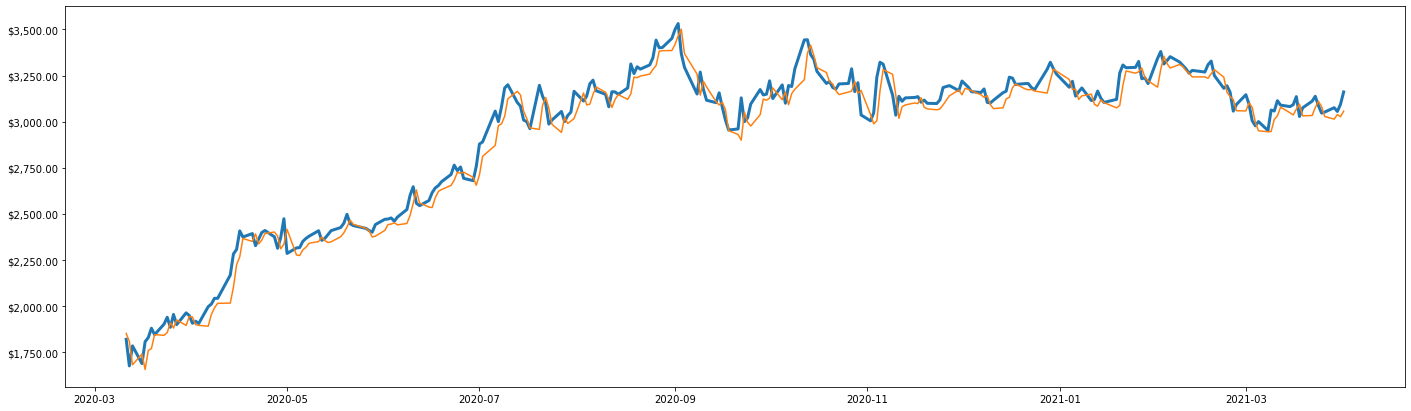

In [23]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2020') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.adjustedclose, linewidth = 3.0)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

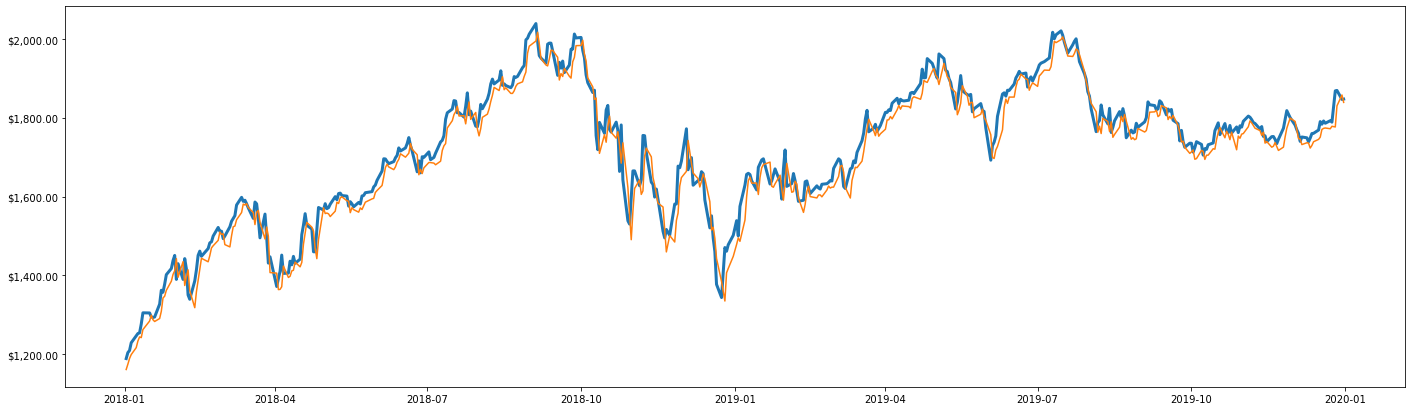

In [24]:
fig4, ax = plt.subplots(figsize = (24,7))
fig4_data = preds_train[(preds_train.index >= '1-1-2018') & (preds_train.index <= '1-1-2020')]
ax.plot(fig4_data.adjustedclose, linewidth = 3.0)
ax.plot(fig4_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');